In [25]:
import itertools
import os

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

from vibrojet.basis_utils import ContrBasis, HermiteBasis
from vibrojet.keo import Gmat, com, pseudo
from vibrojet.potentials import h2co_AYTY
from vibrojet.taylor import deriv_list

plt.rcParams.update(
    {"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern"]}
)

jax.config.update("jax_enable_x64", True)

Equilibrium coordinates, around which the Taylor series expansions will be build

In [2]:
vmin = optimize.minimize(
    h2co_AYTY.poten, [1, 1, 1, 120 * np.pi / 180, 120 * np.pi / 180, np.pi]
)
r0 = vmin.x
v0 = vmin.fun
print("Equilibrium coordinates:", r0)
print("Min of the potential:", v0)

# r0 = np.array([1.20337419, 1.10377465, 1.10377465, 2.1265833, 2.1265833, np.pi])

Equilibrium coordinates: [1.20337419 1.10377465 1.10377465 2.1265833  2.1265833  3.14159265]
Min of the potential: 3.0346763583235566e-11


Define internal to Cartesian coordinate transformation

In [3]:
masses = [12.0, 15.99491463, 1.00782505, 1.00782505]  # masses of C, O, H, H

ncoo = len(r0)


# @eckart(r0, masses)
@com(masses)
def internal_to_cartesian(internal_coords):
    rCO, rCH1, rCH2, aOCH1, aOCH2, tau = internal_coords
    xyz = [
        [0.0, 0.0, 0.0],
        [0.0, 0.0, rCO],
        [
            rCH1 * jnp.sin(aOCH1) * jnp.cos(tau * 0.5),
            -rCH1 * jnp.sin(aOCH1) * jnp.sin(tau * 0.5),
            rCH1 * jnp.cos(aOCH1),
        ],
        [
            rCH2 * jnp.sin(aOCH2) * jnp.cos(tau * 0.5),
            rCH2 * jnp.sin(aOCH2) * jnp.sin(tau * 0.5),
            rCH2 * jnp.cos(aOCH2),
        ],
    ]
    return jnp.array(xyz, dtype=jnp.float64)

Generate $N$-mode expansions for the KEO and PES

In [4]:
# expansion of G-matrix

gmat_max_nmode = 6  # max N-mode expansion order
gmat_max_order = 8  # max total expansion order

gmat_terms = np.array(
    [
        elem
        for elem in itertools.product(
            *[range(0, gmat_max_order + 1) for _ in range(len(r0))]
        )
        if np.count_nonzero(elem) <= gmat_max_nmode and sum(elem) <= gmat_max_order
    ]
)
print("Max N-mode expansion order for G-matrix:", gmat_max_nmode)
print("Max expansion order for G-matrix:", gmat_max_order)
print("Number of expansion terms in G-matrix:", len(gmat_terms))

gmat_file = f"_h2co_gmat_coefs_n_{gmat_max_nmode}.npy"
if os.path.exists(gmat_file):
    print(
        f"load G-matrix expansion coefs from file {gmat_file} (delete file to recompute coefs)"
    )
    gmat_coefs = np.load(gmat_file)
else:
    gmat_coefs = deriv_list(
        lambda x: Gmat(x, masses, internal_to_cartesian), gmat_terms, r0, if_taylor=True
    )
    np.save(gmat_file, gmat_coefs)

Max N-mode expansion order for G-matrix: 6
Max expansion order for G-matrix: 8
Number of expansion terms in G-matrix: 3003
load G-matrix expansion coefs from file _h2co_gmat_coefs_n_6.npy (delete file to recompute coefs)


In [5]:
# expansion of pseudopotential

pseudo_max_nmode = 6  # max N-mode expansion order
pseudo_max_order = 8  # max total expansion order

pseudo_terms = np.array(
    [
        elem
        for elem in itertools.product(
            *[range(0, pseudo_max_order + 1) for _ in range(len(r0))]
        )
        if np.count_nonzero(elem) <= pseudo_max_nmode and sum(elem) <= pseudo_max_order
    ]
)
print("Max N-mode expansion order for pseudopotential:", pseudo_max_nmode)
print("Max expansion order for pseudopotential:", pseudo_max_order)
print("Number of expansion terms in pseudopotential:", len(pseudo_terms))

pseudo_file = f"_h2co_pseudo_coefs_n_{pseudo_max_nmode}.npy"

if os.path.exists(pseudo_file):
    print(
        f"load pseudopotential expansion coefs from file {pseudo_file} (delete file to recompute coefs)"
    )
    pseudo_coefs = np.load(pseudo_file)
else:
    pseudo_coefs = deriv_list(
        lambda x: pseudo(x, masses, internal_to_cartesian),
        pseudo_terms,
        r0,
        if_taylor=True,
    )
    np.save(pseudo_file, pseudo_coefs)

Max N-mode expansion order for pseudopotential: 6
Max expansion order for pseudopotential: 8
Number of expansion terms in pseudopotential: 3003
load pseudopotential expansion coefs from file _h2co_pseudo_coefs_n_6.npy (delete file to recompute coefs)


In [6]:
# expansion of potential

poten_max_nmode = 6  # max N-mode expansion order
poten_max_order = 8  # max total expansion order

poten_terms = np.array(
    [
        elem
        for elem in itertools.product(
            *[range(0, poten_max_order + 1) for _ in range(len(r0))]
        )
        if np.count_nonzero(elem) <= poten_max_nmode and sum(elem) <= poten_max_order
    ]
)
print("Max N-mode expansion order for potential:", poten_max_nmode)
print("Max expansion order for potential:", poten_max_order)
print("Number of expansion terms in potential:", len(poten_terms))

poten_file = f"_h2co_poten_coefs_n_{poten_max_nmode}.npy"
if os.path.exists(poten_file):
    print(
        f"load potential expansion coefs from file {poten_file} (delete file to recompute coefs)"
    )
    poten_coefs = np.load(poten_file)
else:
    poten_coefs = deriv_list(h2co_AYTY.poten, poten_terms, r0, if_taylor=True)
    np.save(poten_file, poten_coefs)

Max N-mode expansion order for potential: 6
Max expansion order for potential: 8
Number of expansion terms in potential: 3003
load potential expansion coefs from file _h2co_poten_coefs_n_6.npy (delete file to recompute coefs)


Define linear mapping between coordinates of Hermite functions and internal coordinates

In [7]:
mask = gmat_terms != 0
ind0 = np.where(mask.sum(axis=1) == 0)[0][0]
mu = np.diag(gmat_coefs[ind0])[:ncoo]

mask = poten_terms != 0
ind2 = np.array(
    [
        np.where((mask.sum(axis=1) == 1) & (poten_terms[:, icoo] == 2))[0][0]
        for icoo in range(ncoo)
    ]
)
freq = poten_coefs[ind2] * 2

lin_a = np.sqrt(np.sqrt(mu / freq))
lin_b = r0

print("x->r linear mapping parameters 'a':", lin_a)
print("x->r linear mapping parameters 'b':", lin_b)

# x->r linear mapping function
x_to_r_map = lambda x, icoo: lin_a[icoo] * x + lin_b[icoo]

x->r linear mapping parameters 'a': [0.05234934 0.11034365 0.11034365 0.15407403 0.15407403 0.2994783 ]
x->r linear mapping parameters 'b': [1.20337419 1.10377465 1.10377465 2.1265833  2.1265833  3.14159265]


Define primitive Hermite basis

In [8]:
ncoo = len(r0)
nbas = [40] * ncoo
npoints = [60] * ncoo

p_r1, p_r2, p_r3, p_alpha1, p_alpha2, p_tau = [
    HermiteBasis(
        icoo,
        nbas[icoo],
        npoints[icoo],
        lambda x: x_to_r_map(x, icoo),
        lambda r: r - r0[icoo],
        lambda r: r - r0[icoo],
        gmat_terms[:, icoo],
        poten_terms[:, icoo],
        pseudo_terms[:, icoo],
    )
    for icoo in range(ncoo)
]

In [9]:
emax = [20000, 40000, 40000, 40000, 40000, 20000]
c_r1, c_r2, c_r3, c_alpha1, c_alpha2, c_tau = [
    ContrBasis(
        (icoo,),
        [p_r1, p_r2, p_r3, p_alpha1, p_alpha2, p_tau],
        lambda _: True,
        gmat_terms,
        gmat_coefs,
        poten_terms,
        poten_coefs,
        pseudo_terms,
        pseudo_coefs,
        emax=emax[icoo],
    )
    for icoo in range(ncoo)
]

e = c_r1.enr
print("Solutions for r1 mode:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_r2.enr
print("\nSolutions for r2 mode:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_r3.enr
print("\nSolutions for r3 mode:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_alpha1.enr
print("Solutions for alpha1 mode:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_alpha2.enr
print("Solutions for alpha2 mode:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_tau.enr
print("Solutions for tau mode:\n", f"zpe = {e[0]}\n", e - e[0])

Solutions for r1 mode:
 zpe = 3498.622453697404
 [    0.          1765.59185249  3507.97213596  5227.09104811
  6922.89277513  8595.31921918 10244.31575133 11869.83967929
 13471.8723018  15050.43562243 16605.61504224 18137.59058098
 19646.69391134]

Solutions for r2 mode:
 zpe = 3747.7969591006545
 [    0.          2832.01723723  5534.75443869  8110.24908761
 10579.77430977 12996.9118743  15435.46734594 17954.83365504
 20584.98179535 23335.97581293 26209.07872477 29202.25620833
 32312.3584228  35535.96564321 38869.72004322]

Solutions for r3 mode:
 zpe = 3747.7969592297713
 [    0.          2832.01723733  5534.75443889  8110.24908789
 10579.7743101  12996.91187461 15435.46734617 17954.83365515
 20584.9817953  23335.97581272 26209.07872438 29202.25620777
 32312.35842205 35535.96564228 38869.7200421 ]
Solutions for alpha1 mode:
 zpe = 3438.9156162374857
 [    0.          1498.26736549  2996.22979873  4493.79468233
  5990.86688008  7487.34856246  8983.13901417 10478.13442176
 11972.227638

In [10]:
c_r2_r3 = ContrBasis(
    (1, 2),
    [c_r1, c_r2, c_r3, c_alpha1, c_alpha2, c_tau],
    lambda _: True,
    gmat_terms,
    gmat_coefs,
    poten_terms,
    poten_coefs,
    pseudo_terms,
    pseudo_coefs,
    emax=20000,
)

e = c_r2_r3.enr
print(len(e))
print("Solutions for r2+r3 modes:\n", f"zpe = {e[0]}\n", e - e[0])

36
Solutions for r2+r3 modes:
 zpe = 4440.896400586282
 [    0.          2820.55385857  2865.05025524  5542.5987338
  5558.32247397  5702.46007581  8136.71763003  8139.94310637
  8373.83103409  8452.73490827 10618.22244499 10618.80082649
 10970.85472825 11007.90216867 11159.32188062 13042.64623164
 13042.77008591 13468.87282807 13480.28268032 13687.14652308
 13790.03250642 15483.58434992 15483.62346112 15901.61699562
 15904.98740928 16169.98233084 16232.19173466 16373.85256982
 18000.23659006 18000.25909224 18345.85648531 18347.32245894
 18612.71241554 18645.66182602 18790.06817796 18901.77820271]


In [11]:
c_alpha1_alpha2 = ContrBasis(
    (3, 4),
    [c_r1, c_r2, c_r3, c_alpha1, c_alpha2, c_tau],
    lambda _: True,
    gmat_terms,
    gmat_coefs,
    poten_terms,
    poten_coefs,
    pseudo_terms,
    pseudo_coefs,
    emax=20000,
)

e = c_alpha1_alpha2.enr
print(len(e))
print("Solutions for alpha1+alpha2 modes:\n", f"zpe = {e[0]}\n", e - e[0])

114
Solutions for alpha1+alpha2 modes:
 zpe = 3672.3352285088026
 [    0.          1259.99557116  1575.28128332  2523.30742172
  2831.42762665  3151.2237783   3790.63220825  4091.20403713
  4403.31304917  4727.30485089  5062.63614333  5355.34025487
  5659.33087877  5975.15179417  6302.98016829  6339.95194636
  6624.53062846  6920.03995923  7227.20995841  7546.42392287
  7623.17670577  7877.6788564   7899.43033357  8186.16223553
  8484.27451808  8794.34493256  8912.87058176  9116.58518209
  9180.65287163  9450.79778478  9458.37448708  9747.09407836
 10047.57010949 10209.55625072 10360.21702127 10468.76874197
 10685.06179412 10737.3056139  11016.36569303 11021.69471269
 11306.87348379 11513.71897781 11609.43205801 11764.30513051
 11924.28020402 12023.53545591 12251.24421304 12292.7320669
 12572.9706993  12589.67993503 12825.8072     12865.02831151
 13067.74643365 13169.34032739 13317.59490278 13485.95546479
 13576.78067423 13814.47951899 13846.51622752 14127.73807252
 14146.23354917 1415

In [12]:
e_max = 10000

e1 = np.copy(c_r1.enr - c_r1.enr[0])
e23 = np.copy(c_r2_r3.enr - c_r2_r3.enr[0])
e45 = np.copy(c_alpha1_alpha2.enr - c_alpha1_alpha2.enr[0])
e6 = np.copy(c_tau.enr - c_tau.enr[0])


def select_quanta(ind):
    i1, i23, i45, i6 = ind
    cond = e1[i1] + e23[i23] + e45[i45] + e6[i6] <= e_max
    return cond


sol = ContrBasis(
    (0, 1, 2, 3),
    [c_r1, c_r2_r3, c_alpha1_alpha2, c_tau],
    select_quanta,
    gmat_terms,
    gmat_coefs,
    poten_terms,
    poten_coefs,
    pseudo_terms,
    pseudo_coefs,
    emax=20000,
    store_me=False,
)

e = sol.enr
print(len(e))
print("Solutions:\n", f"zpe = {e[0]}\n", e - e[0])

541
Solutions:
 zpe = 5789.947801049568
 [    0.          1167.21402802  1249.83452974  1500.69998015
  1747.04815679  2327.95190752  2424.16622643  2497.3061746
  2669.25656538  2722.79658458  2785.08870915  2846.44218376
  2909.01278715  3003.40394573  3005.07128814  3245.6281825
  3480.56527489  3483.46504495  3588.89527852  3679.7711795
  3743.29024381  3831.73391658  3894.20069385  3945.27444716
  3945.67498085  4001.15794336  4028.86367945  4064.21764454
  4090.73421124  4171.51216004  4178.11838737  4208.42829953
  4257.75913678  4266.85268866  4349.21548891  4410.71977597
  4482.42256448  4518.7530155   4542.49350304  4583.81947861
  4635.44663748  4636.22657166  4749.48579317  4750.6323435
  4755.80895518  4852.04915507  4940.61752439  4983.92631912
  4995.49457876  5007.10627587  5061.79948496  5104.11821949
  5128.63757229  5157.92912063  5175.52552994  5200.06038295
  5200.75915368  5252.63571583  5270.06558264  5273.85170799
  5347.76872907  5364.24850755  5371.40886268  5

In [8]:
nmode_list = list(
    set(
        [
            (n, 6, 6) if i == 0 else (6, n, 6) if i == 1 else (6, 6, n)
            for i in range(3)
            for n in range(1, 7)
        ]
    )
)

nmode_enr = {}

for nmode_gmat, nmode_poten, nmode_pseudo in nmode_list:
    print(
        f"\nRun for N-mode G-matrix/potential/pseudopotential = {nmode_gmat}/{nmode_poten}/{nmode_pseudo} ..."
    )
    ind = np.where(np.count_nonzero(gmat_terms, axis=1) <= nmode_gmat)[0]
    gmat_terms_nmode = gmat_terms[ind]
    gmat_coefs_nmode = gmat_coefs[ind]

    ind = np.where(np.count_nonzero(poten_terms, axis=1) <= nmode_poten)[0]
    poten_terms_nmode = poten_terms[ind]
    poten_coefs_nmode = poten_coefs[ind]

    ind = np.where(np.count_nonzero(pseudo_terms, axis=1) <= nmode_pseudo)[0]
    pseudo_terms_nmode = pseudo_terms[ind]
    pseudo_coefs_nmode = pseudo_coefs[ind]

    ncoo = len(r0)
    nbas = [40] * ncoo
    npoints = [60] * ncoo

    p_r1, p_r2, p_r3, p_alpha1, p_alpha2, p_tau = [
        HermiteBasis(
            icoo,
            nbas[icoo],
            npoints[icoo],
            lambda x: x_to_r_map(x, icoo),
            lambda r: r - r0[icoo],
            lambda r: r - r0[icoo],
            gmat_terms_nmode[:, icoo],
            poten_terms_nmode[:, icoo],
            pseudo_terms_nmode[:, icoo],
        )
        for icoo in range(ncoo)
    ]

    emax = [20000, 40000, 40000, 40000, 40000, 20000]

    c_r1, c_r2, c_r3, c_alpha1, c_alpha2, c_tau = [
        ContrBasis(
            (icoo,),
            [p_r1, p_r2, p_r3, p_alpha1, p_alpha2, p_tau],
            lambda _: True,
            gmat_terms_nmode,
            gmat_coefs_nmode,
            poten_terms_nmode,
            poten_coefs_nmode,
            pseudo_terms_nmode,
            pseudo_coefs_nmode,
            emax=emax[icoo],
        )
        for icoo in range(ncoo)
    ]

    c_r2_r3 = ContrBasis(
        (1, 2),
        [c_r1, c_r2, c_r3, c_alpha1, c_alpha2, c_tau],
        lambda _: True,
        gmat_terms_nmode,
        gmat_coefs_nmode,
        poten_terms_nmode,
        poten_coefs_nmode,
        pseudo_terms_nmode,
        pseudo_coefs_nmode,
        emax=20000,
    )

    c_alpha1_alpha2 = ContrBasis(
        (3, 4),
        [c_r1, c_r2, c_r3, c_alpha1, c_alpha2, c_tau],
        lambda _: True,
        gmat_terms_nmode,
        gmat_coefs_nmode,
        poten_terms_nmode,
        poten_coefs_nmode,
        pseudo_terms_nmode,
        pseudo_coefs_nmode,
        emax=20000,
    )

    e_max = 12000
    e1 = np.copy(c_r1.enr - c_r1.enr[0])
    e23 = np.copy(c_r2_r3.enr - c_r2_r3.enr[0])
    e45 = np.copy(c_alpha1_alpha2.enr - c_alpha1_alpha2.enr[0])
    e6 = np.copy(c_tau.enr - c_tau.enr[0])

    def select_quanta(ind):
        i1, i23, i45, i6 = ind
        cond = e1[i1] + e23[i23] + e45[i45] + e6[i6] <= e_max
        return cond

    sol = ContrBasis(
        (0, 1, 2, 3),
        [c_r1, c_r2_r3, c_alpha1_alpha2, c_tau],
        select_quanta,
        gmat_terms_nmode,
        gmat_coefs_nmode,
        poten_terms_nmode,
        poten_coefs_nmode,
        pseudo_terms_nmode,
        pseudo_coefs_nmode,
        emax=20000,
        store_me=False,
    )

    e = sol.enr - sol.enr[0]
    print(e[:10])
    nmode_enr[(nmode_gmat, nmode_poten, nmode_pseudo)] = e[:101]


Run for N-mode G-matrix/potential/pseudopotential = 4/6/6 ...
[   0.         1166.98217963 1249.55460698 1500.12418175 1746.15067642
 2326.8576776  2422.75584365 2495.35161023 2666.80034114 2719.82198412]

Run for N-mode G-matrix/potential/pseudopotential = 6/6/6 ...
[   0.         1166.98218206 1249.55460035 1500.1241549  1746.1507101
 2326.8576807  2422.75584117 2495.35160381 2666.80031835 2719.82193749]

Run for N-mode G-matrix/potential/pseudopotential = 6/1/6 ...
[   0.         1188.74976711 1274.03409085 1534.09276004 1793.78938463
 2383.5972494  2463.48444044 2540.43232268 2725.29172186 2777.05253619]

Run for N-mode G-matrix/potential/pseudopotential = 6/3/6 ...
[   0.         1167.02434832 1249.79358986 1499.99888341 1746.15036016
 2326.95309915 2423.17405122 2495.70101546 2666.61916364 2719.86012782]

Run for N-mode G-matrix/potential/pseudopotential = 6/4/6 ...
[   0.         1166.98226322 1249.55483273 1500.12405772 1746.15069143
 2326.85785227 2422.75686909 2495.35195618 

In [23]:
np.savez("_h2co_nmode_enr.npz", **{str(key): val for key, val in nmode_enr.items()})

Define linear mapping between coordinates of Hermite functions and internal coordinates

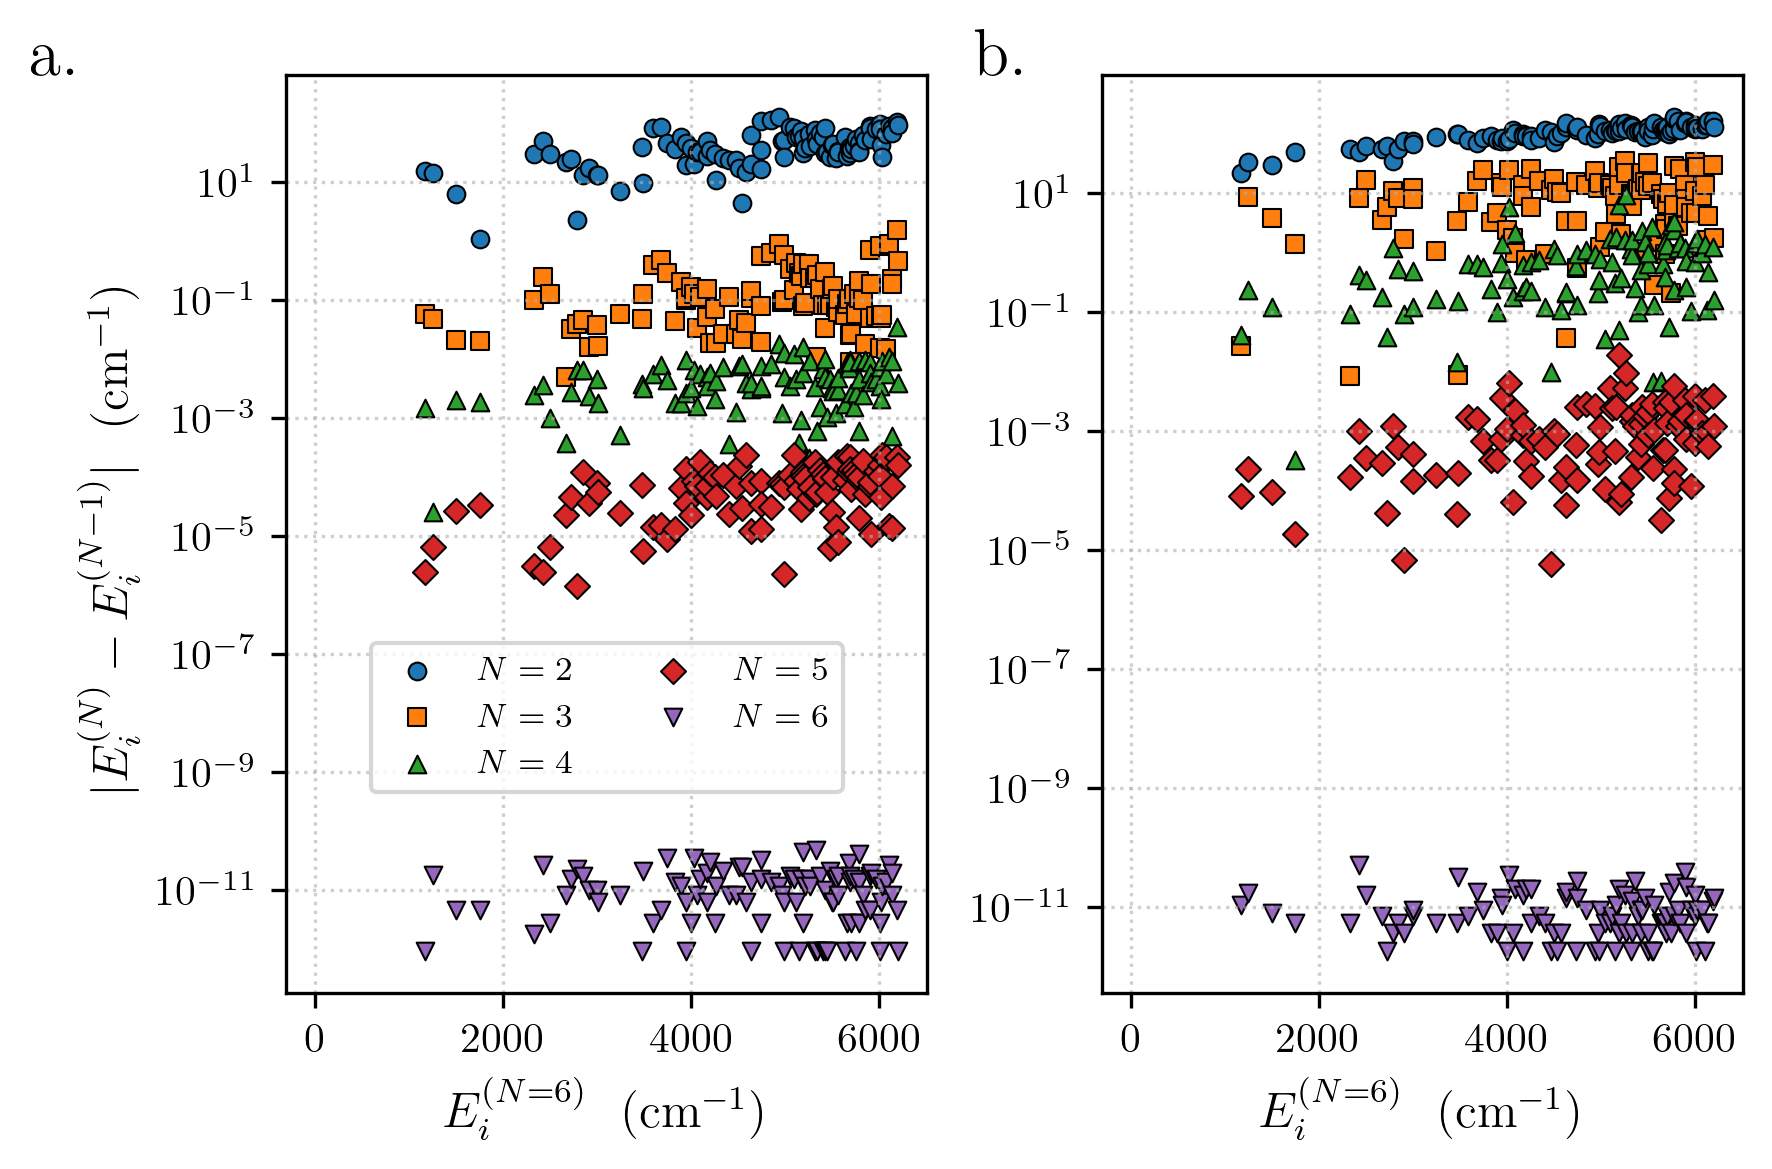

In [119]:
import matplotlib.pyplot as plt

data = np.load("_h2co_nmode_enr.npz")
enr = {eval(key): data[key] for key in data.files}

de_gmat = np.array([np.abs(enr[(n, 6, 6)] - enr[(n - 1, 6, 6)]) for n in range(2, 7)])
de_poten = np.array([np.abs(enr[(6, n, 6)] - enr[(6, n - 1, 6)]) for n in range(2, 7)])
# label = [n for n in range(2, 7)]

fig, axes = plt.subplots(1, 2, figsize=(6, 4), dpi=300)
for i, (ax, de) in enumerate(zip(axes, (de_gmat, de_poten))):
    for n, (d, marker) in enumerate(zip(de, ("o", "s", "^", "D", "v"))):
        ax.scatter(
            enr[(6, 6, 6)],
            d,
            marker=marker,
            s=18,
            edgecolors="black",
            linewidths=0.5,
            label=f"$N={n+2}$",
        )

    ax.set_yscale("log")
    ax.set_xlabel("$E_i^{(N=6)}$~~(${\\rm cm}^{-1}$)", fontsize=12)
    if i == 0:
        ax.set_ylabel("$|E_i^{(N)}-E_i^{(N-1)}|$~~(${\\rm cm}^{-1})$", fontsize=12)
        ax.legend(
            fontsize=8,
            ncol=2,
            loc="center",
            bbox_to_anchor=(0.5, 0.3),
        )
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.tick_params(axis="both", labelsize=10)

# Add panel labels
axes[0].text(
    -0.4,
    1.05,
    "a.",
    transform=axes[0].transAxes,
    fontsize=16,
    fontweight="bold",
    va="top",
    ha="left",
)

axes[1].text(
    -0.2,
    1.05,
    "b.",
    transform=axes[1].transAxes,
    fontsize=16,
    fontweight="bold",
    va="top",
    ha="left",
)
plt.tight_layout()
fig.savefig(f"_h2co_nmode_enr.pdf", format="pdf", bbox_inches="tight")